In [27]:
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder
import matplotlib.pyplot as plt


In [28]:
model_species = pd.read_excel('model_definition_simple_ex.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl')
model_rxns = pd.read_excel('model_definition_simple_ex.xlsx', sheet_name = 'Reaction', engine = 'openpyxl')

In [52]:
modelfile = 'new_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))

enzymeInit = 0.5

In [53]:
results = []
s = r.simulate(0,10)

for sda in sdaV:
    for pcx in pcxV:
        for mdh in mdhV:
            r['['+sda+']'] = enzymeInit
            r['['+pcx+']'] = enzymeInit
            r['['+mdh+']'] = enzymeInit
            
            s = r.simulate(0,10)
            results.append(s['[MALICACID]'][-1])
            r.reset()
            
            

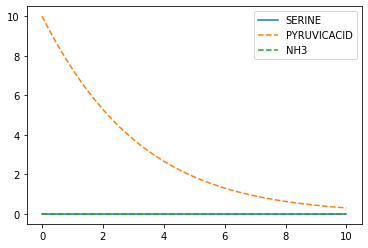

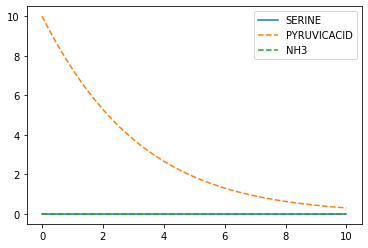

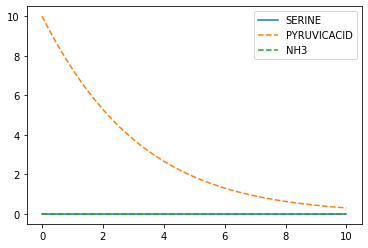

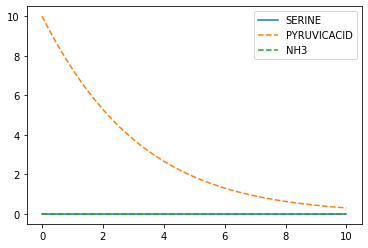

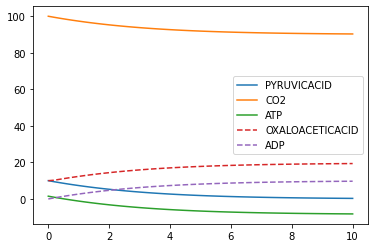

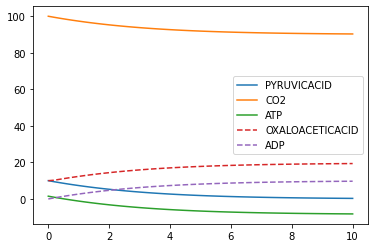

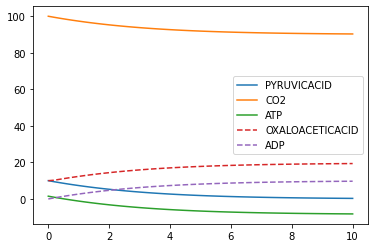

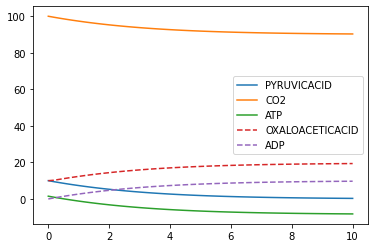

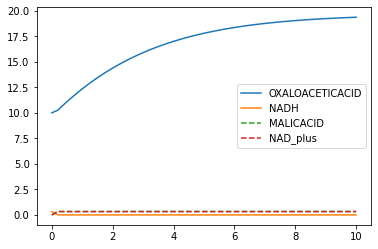

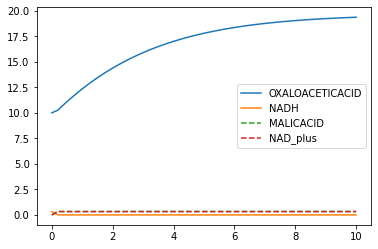

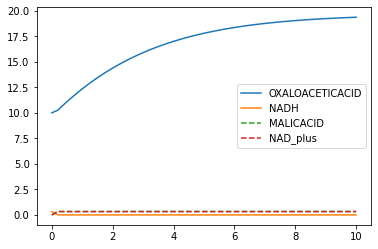

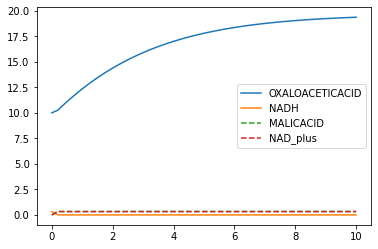

In [54]:
for k,r in model_rxns.iterrows():
    plt.figure()
    for j in myModel.get_substrates(k):
        plt.plot(s['time'],s['['+j+']'], label = j)
        
    for j in myModel.get_products(k):
        plt.plot(s['time'],s['['+j+']'],'--', label = j)  
    plt.legend()


In [55]:
results

[0.32999999999795043,
 0.32999999999993496,
 0.3299999999998334,
 0.3299999999999568,
 0.3299999999999998,
 0.32999999999999924,
 0.33000000000000007,
 0.33000000000000007,
 0.3299999999999994,
 0.3300000000000002,
 0.3300000000000003,
 0.3300000000000001,
 0.3300000000000052,
 0.33,
 0.33000000000000074,
 0.3300000000029031,
 0.32999999999795043,
 0.32999999999993496,
 0.3299999999998334,
 0.3299999999999568,
 0.3299999999999998,
 0.32999999999999924,
 0.33000000000000007,
 0.33000000000000007,
 0.3299999999999994,
 0.3300000000000002,
 0.3300000000000003,
 0.3300000000000001,
 0.3300000000000052,
 0.33,
 0.33000000000000074,
 0.3300000000029031,
 0.32999999999795043,
 0.32999999999993496,
 0.3299999999998334,
 0.3299999999999568,
 0.3299999999999998,
 0.32999999999999924,
 0.33000000000000007,
 0.33000000000000007,
 0.3299999999999994,
 0.3300000000000002,
 0.3300000000000003,
 0.3300000000000001,
 0.3300000000000052,
 0.33,
 0.33000000000000074,
 0.3300000000029031,
 0.3299999999979